In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics
from sklearn import svm


from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [3]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(
    palm_file, 
    n_omg_channels=50,
    n_acc_channels=3, 
    n_gyr_channels=3, 
    n_enc_channels=6, 
    n_mag_channels=0
)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [4]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [5]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


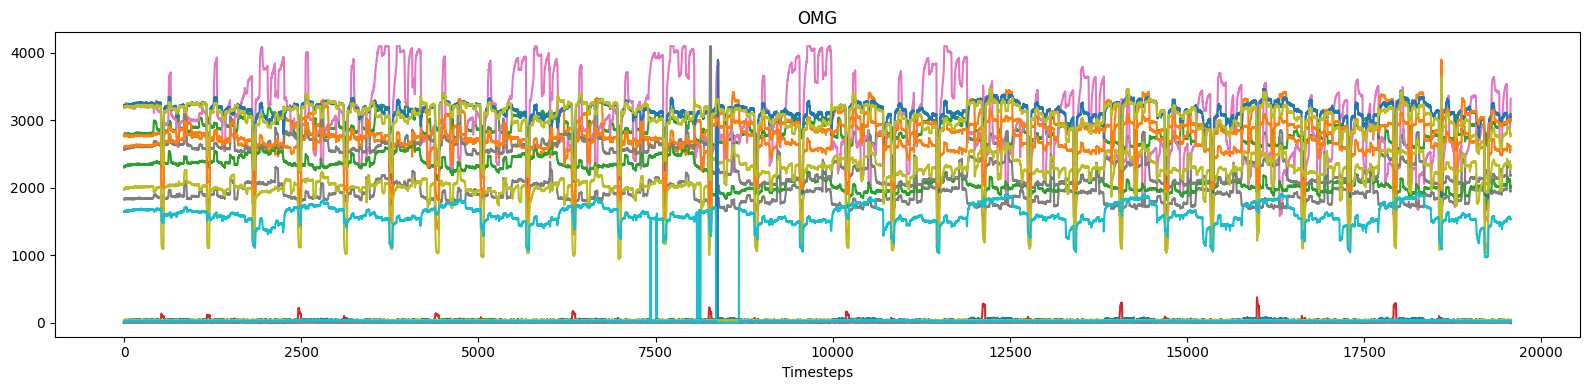

In [6]:
fig = plt.figure(figsize=(16, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [7]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
print('Shape of data:', gestures_protocol.shape)
gestures_protocol.head()

Shape of data: (181, 11)


,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [8]:
le = preprocessing.LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [9]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [10]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

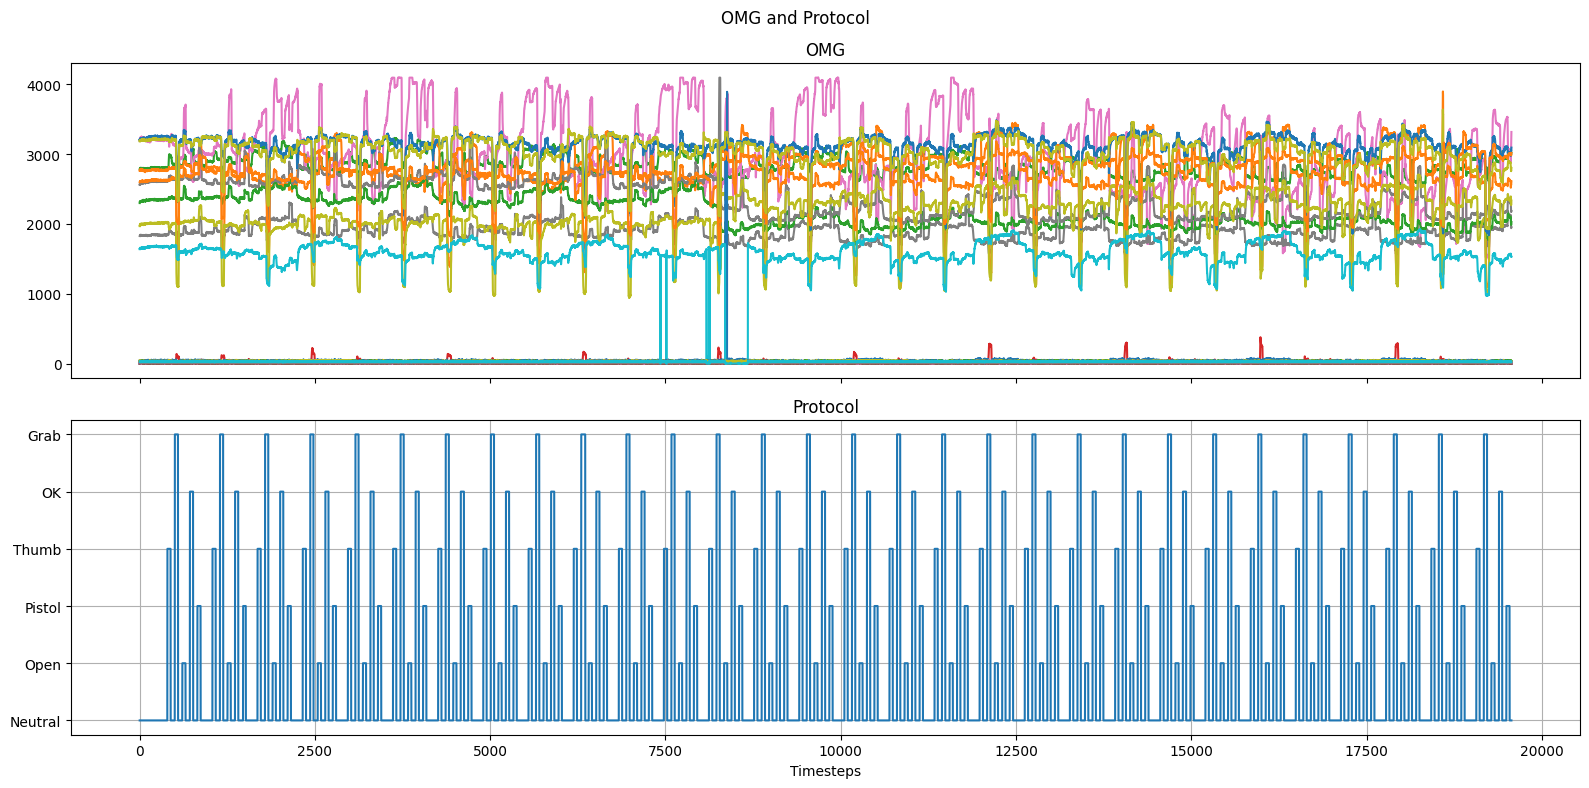

In [11]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Train-test split

In [12]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441
5,2023-06-20_13-30-15.palm,1,17928,17928,4435
6,2023-06-20_12-34-17.palm,1,17758,17758,4444
7,2023-09-30_08-06-44.palm,2,5693,5693,5509
8,2023-09-29_11-03-50.palm,2,5694,5694,5511
9,2023-09-29_09-20-47.palm,2,5690,5690,5507


In [13]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

---
---
---
---
---

# Preprocessing

In [14]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

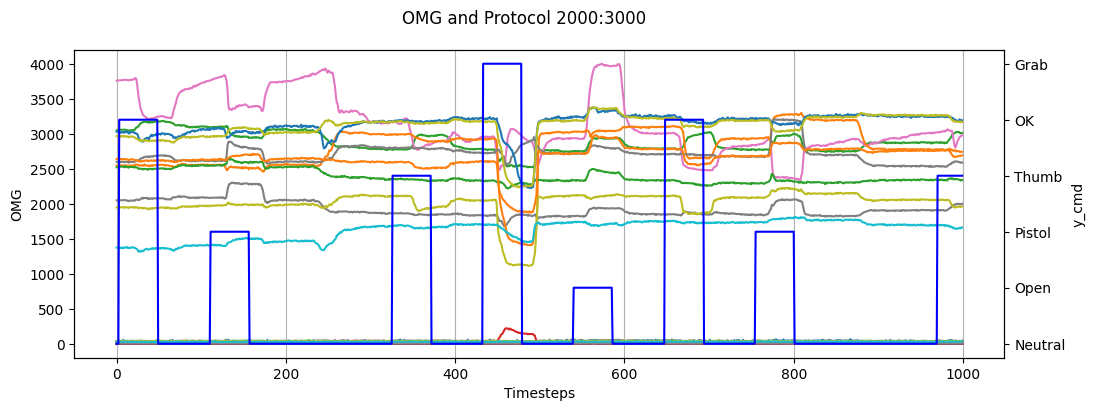

In [15]:
get_graphs(gestures[OMG_CH].values, y_cmd, start=2000, end=3000)

## Глобальное устранение лага между сигналами датчиков и таргетом

In [16]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

Сдвинем таргет в обеих выборках вдоль всех данных на оптимальный шаг.

In [17]:
X = gestures[OMG_CH].values
fitting_model = svm.LinearSVC(dual='auto')
y_shifted, summary = get_naive_centering(X, y_cmd, inter=500, window=30, model=fitting_model)
print(*summary, sep='')

Оптимальные свдиги для концевых выборок:   17 и 21
Accuracy/correlation на концевых выборках: 0.998; 0.998
Размер оптимального сдвига (как среднего): 19


Посмотрим на результат.

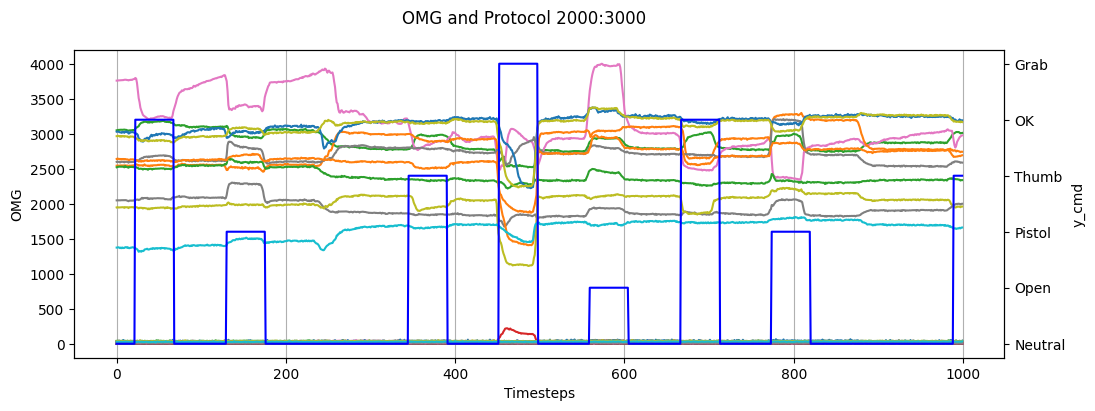

In [18]:
get_graphs(X, y_shifted, start=2000, end=3000)

## Экспоненциальное сглаживаение

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def Exp_Smoothing(X: np.ndarray, sl: float=0.5) -> np.ndarray:
    assert len(X.shape) == 2
    X_result = np.zeros((X.shape[0]))
    for i in range(X.shape[1]):
        data = X[:, i]
        model = ExponentialSmoothing(data)
        fit_model = model.fit(smoothing_level=sl, optimized=False)
        smoothed_data = fit_model.fittedvalues
        X_result = np.column_stack((X_result, smoothed_data))
    
    return X_result[:, 1:]

In [20]:
X_es = Exp_Smoothing(X)

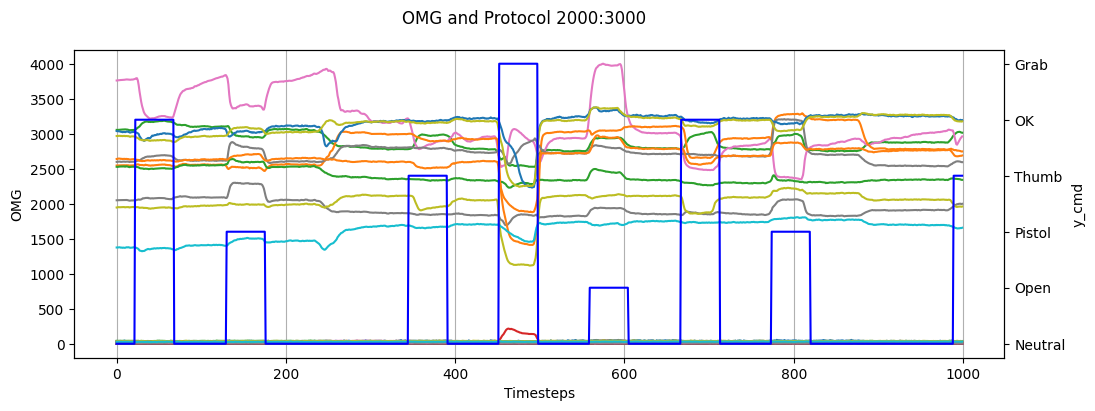

In [21]:
get_graphs(X_es, y_shifted, start=2000, end=3000)

## Корреляционный анализ

In [22]:
def find_highly_correlated_features(data, threshold=0.9):
    # Строим корреляционную матрицу
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Находим индексы нижнего треугольника корреляционной матрицы
    lower_triangle_indices = np.tril_indices(corr_matrix.shape[0], k=-1)
    
    # Находим пары высоко скоррелированных признаков
    high_corr_features = [
        [i, j] for i, j in zip(
            lower_triangle_indices[0], lower_triangle_indices[1]
        ) if abs(corr_matrix[i, j]) > threshold
    ]

    # Определяем features_to_remove
    features_to_remove = []
    for i in range(len(high_corr_features)):
        for j in range(2):
            cnt = 0
            for k in range(len(high_corr_features)):
                if high_corr_features[i][j] in high_corr_features[k]:
                    cnt += 1
            
            if cnt > 1:
                features_to_remove.append(high_corr_features[i][j])
            else:
                if high_corr_features[i][0] not in features_to_remove:
                    features_to_remove.append(high_corr_features[i][1])
                else:
                    continue

    return high_corr_features, set(features_to_remove)

In [23]:
_, features_to_remove = find_highly_correlated_features(X)
features_to_remove

{28}

Удалим высокоскореллированные признаки.

In [24]:
X_cd = np.delete(X_es, list(features_to_remove), axis=1)

## Стандартизация

In [25]:
std_scaler = preprocessing.StandardScaler()

X_scaled = std_scaler.fit_transform(X_cd)

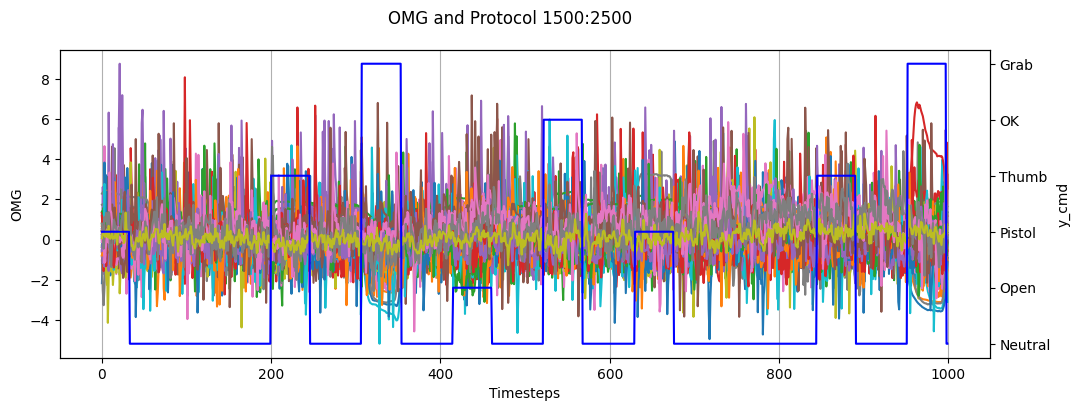

In [26]:
get_graphs(X_scaled, y_shifted, start=1500, end=2500)

## Устранение мультиколлинеарности

In [27]:
# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_scaled).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 49
Ранг матрицы:   49
Определитель:   2.9652472341560967e-12


In [28]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 49


In [29]:
X_pca = pca.transform(X_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 49
Ранг матрицы:   49
Определитель:   0.9999999999999977


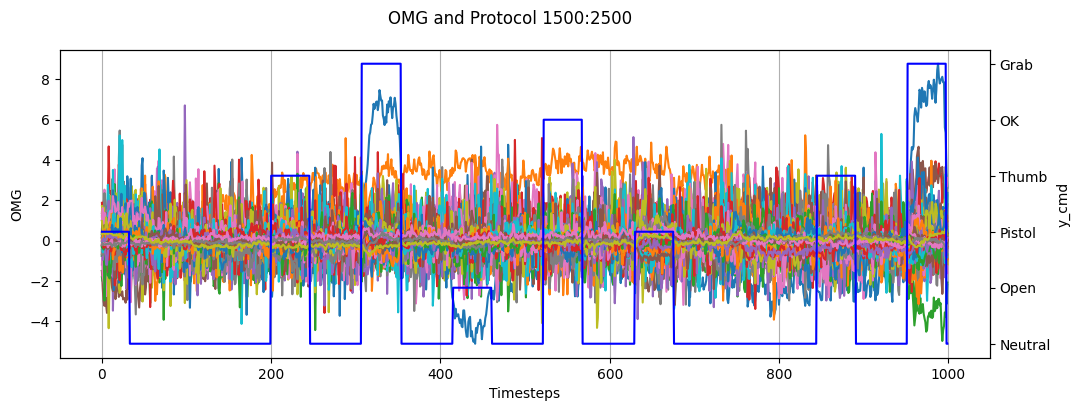

In [30]:
get_graphs(X_pca, y_shifted, start=1500, end=2500)

## Сэмплирование

In [31]:
y_train = y_shifted[:last_train_idx]
y_test = y_shifted[last_train_idx:]
print(y_train.shape)
print(y_test.shape)

(15679,)
(3889,)


In [32]:
# Создаем экземпляр OneHotEncoder
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)

# Преобразуем вектор целевых признаков в матрицу one-hot encoding
y_shifted_e = onehot_encoder.fit_transform(y_shifted.reshape(-1, 1))

print(y_shifted_e.shape)

(19568, 6)


In [33]:
LOOK_BACK_NUM = 10

In [34]:
data_columns = [pd.DataFrame(X_pca).shift(i) for i in range(LOOK_BACK_NUM)]
data = pd.concat(data_columns, axis=1)
data = data.fillna(0)
print(data.shape)

X_nn = data.values.reshape(data.shape[0], LOOK_BACK_NUM, X_pca.shape[1])
print(X_nn.shape)

target_columns = [pd.DataFrame(y_shifted_e).shift(i) for i in range(LOOK_BACK_NUM)]
target = pd.concat(target_columns, axis=1)
target = target.fillna(0)
print(target.shape)

y_nn = target.values.reshape(target.shape[0], LOOK_BACK_NUM, y_shifted_e.shape[1])
print(y_nn.shape)

X_train_nn = X_nn[:last_train_idx]
y_train_nn = y_nn[:last_train_idx]

X_test_nn = X_nn[last_train_idx:]
y_test_nn = y_nn[last_train_idx:]

print(X_train_nn.shape, y_train_nn.shape)
print(X_test_nn.shape, y_test_nn.shape)

(19568, 490)
(19568, 10, 49)
(19568, 60)
(19568, 10, 6)
(15679, 10, 49) (15679, 10, 6)
(3889, 10, 49) (3889, 10, 6)


# Modeling

In [35]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from keras import callbacks

In [36]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(None, n_channels))

x = tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=0.5)(x)
x = tf.keras.layers.LSTM(units=16, return_sequences=True, dropout=0.2)(x)

output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

input_shape = (10, 49) | output_units = 6



Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 49)]        0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          10496     
                                                                 
 lstm_1 (LSTM)               (None, None, 16)          3136      
                                                                 
 dense (Dense)               (None, None, 6)           102       
                                                                 
Total params: 13734 (53.65 KB)
Trainable params: 13734 (53.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
m = tf.keras.models.clone_model(model)

m.compile(
    loss="categorical_crossentropy",
    metrics=[Precision(), Recall()],
    optimizer=tf.keras.optimizers.experimental.Adam()
)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min", patience=20,
    restore_best_weights=True
)

his = m.fit(
    X_train_nn,
    y_train_nn,
    batch_size=16,
    epochs=300,
    verbose=1,
    validation_split=0.25,
    callbacks=[earlystopping]
)

Epoch 1/300

735/735 [==============================] - 7s 6ms/step - loss: 0.7313 - precision: 0.8772 - recall: 0.6293 - val_loss: 0.4243 - val_precision: 0.9229 - val_recall: 0.8088
Epoch 2/300
735/735 [==============================] - 3s 5ms/step - loss: 0.3817 - precision: 0.9085 - recall: 0.8506 - val_loss: 0.3380 - val_precision: 0.9234 - val_recall: 0.8856
Epoch 3/300
735/735 [==============================] - 3s 5ms/step - loss: 0.3210 - precision: 0.9175 - recall: 0.8836 - val_loss: 0.2890 - val_precision: 0.9294 - val_recall: 0.9086
Epoch 4/300
735/735 [==============================] - 3s 5ms/step - loss: 0.2945 - precision: 0.9203 - recall: 0.8926 - val_loss: 0.2819 - val_precision: 0.9299 - val_recall: 0.9129
Epoch 5/300
735/735 [==============================] - 3s 5ms/step - loss: 0.2720 - precision: 0.9238 - recall: 0.9012 - val_loss: 0.2612 - val_precision: 0.9312 - val_recall: 0.9188
Epoch 6/300
735/735 [==============================] - 3s 5ms/step - loss: 0.2610 - 

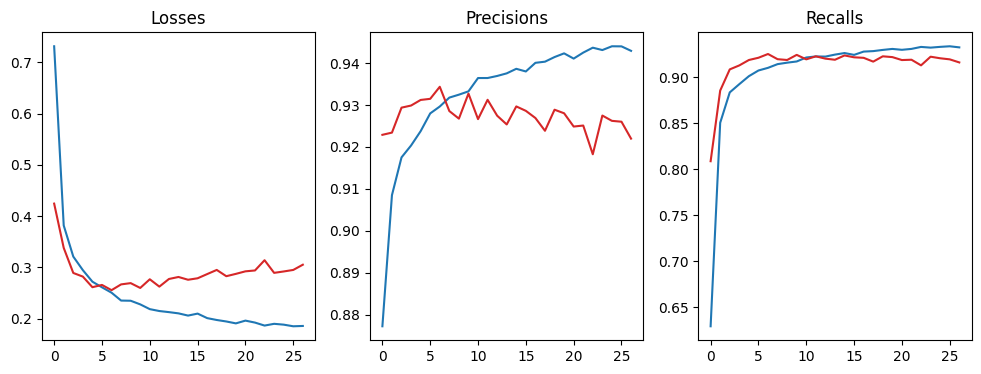

In [38]:
history_keys = list(his.history.keys())

# Создаем подграфики
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 строка, 3 столбца

# Строим графики
axs[0].plot(his.history['loss'], color='tab:blue')
axs[0].plot(his.history['val_loss'], color='tab:red')
axs[0].set_title('Losses')

axs[1].plot(his.history[history_keys[1]], color='tab:blue')
axs[1].plot(his.history[history_keys[4]], color='tab:red')
axs[1].set_title('Precisions')

axs[2].plot(his.history[history_keys[2]], color='tab:blue')
axs[2].plot(his.history[history_keys[5]], color='tab:red')
axs[2].set_title('Recalls')

# Отображаем графики
plt.show()

## Prediction

In [39]:
%%time
y_pred_train_nn = m.predict(X_train_nn)
y_pred_test_nn = m.predict(X_test_nn)

preds_train = np.argmax(y_pred_train_nn, axis=2)[:, 0]
preds_test = np.argmax(y_pred_test_nn, axis=2)[:, 0]

122/122 [==============================] - 0s 2ms/step
CPU times: total: 2.73 s
Wall time: 2.01 s


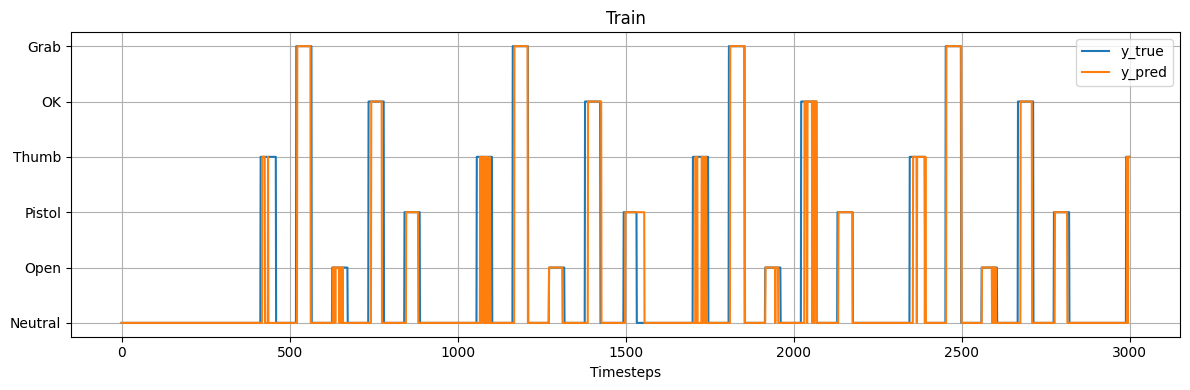

In [40]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_train[:3000],  c='C0', label='y_true')
plt.plot(preds_train[:3000], c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

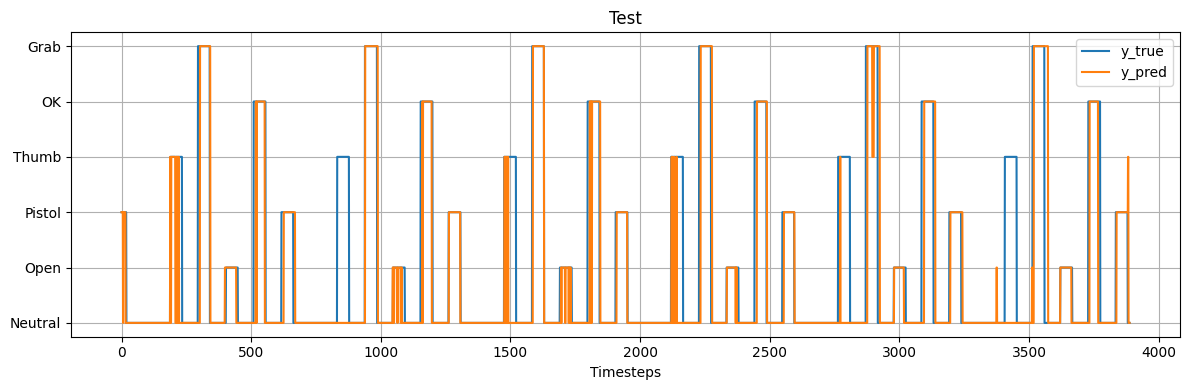

In [41]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_test, c='C0', label='y_true')
plt.plot(preds_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [42]:
print('Train preds metrics report:')
print(metrics.classification_report(
    y_train, preds_train, target_names=GESTURES, digits=4))
print('-'*55)
print('Test preds metrics report:')
print(metrics.classification_report(
    y_test, preds_test, target_names=GESTURES, digits=4))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test, preds_test)
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

Train preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.8789    0.9852    0.9290     10170
        Open     0.9954    0.7853    0.8780      1104
      Pistol     0.9638    0.8387    0.8969      1079
       Thumb     0.9464    0.4955    0.6504      1104
          OK     0.9451    0.7011    0.8050      1104
        Grab     0.9440    0.9052    0.9242      1118

    accuracy                         0.9008     15679
   macro avg     0.9456    0.7852    0.8472     15679
weighted avg     0.9070    0.9008    0.8945     15679

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.8510    0.9731    0.9080      2489
        Open     0.9646    0.7899    0.8685       276
      Pistol     0.9493    0.8881    0.9177       295
       Thumb     0.8222    0.1341    0.2305       276
          OK     0.9462    0.7645    0.8457       276
        Grab     0.88

,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,2422,8,14,2,12,31
Open,58,218,0,0,0,0
Pistol,33,0,262,0,0,0
Thumb,239,0,0,37,0,0
OK,65,0,0,0,211,0
Grab,29,0,0,6,0,242


---
---
---
---
---

# ONNX

In [43]:
import onnx
import tf2onnx
import onnxruntime

In [44]:
onnx_model, _ = tf2onnx.convert.from_keras(model=m)
onnx.save_model(proto=onnx_model, f='model.onnx')
sess = onnxruntime.InferenceSession(path_or_bytes='model.onnx')
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# Real-time inference

In [45]:
import time
from serial import Serial
from IPython.display import clear_output

In [46]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [47]:
def preprocessing(x, prev):
    # x - sample vector
    if prev is None:
        x = np.delete(x.reshape(1, -1), list(features_to_remove), axis=1)
        x_scaled = std_scaler.transform(x)
        x_pca = pca.transform(x_scaled)
        prev = np.zeros((1, LOOK_BACK_NUM, x_pca.shape[-1]))
        prev[0, 0, :] = x_pca
        y = prev
    else:
        x = np.delete(x.reshape(1, -1), list(features_to_remove), axis=1)
        x_scaled = std_scaler.transform(x)
        x_pca = pca.transform(x_scaled)
        
        prev[:, 1:, :] = prev[:, :-1, :]
        prev[:, 0, :] = x_pca
        y = prev

    return y, prev


def inference(x):
    x = x.astype(np.float32)
    y = sess.run(output_names=[output_name], input_feed={input_name: x})
    y = np.argmax(y, axis=2)[:, 0]
    return np.argmax(y)


def postprocessing(x, prev):
    if prev is None:
        prev = np.zeros((5,))
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [48]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [49]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
    
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), f'Calculation cycle takes more than TIMEOUT, halting...\ntime:{ts_diff}'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [50]:
np.max(ts_diffs)

0.005002021789550781

In [51]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 1, 10, 49)
y_predicted.shape = (3889,)
y_postprocessed.shape = (3889,)
y_commands.shape = (3889,)


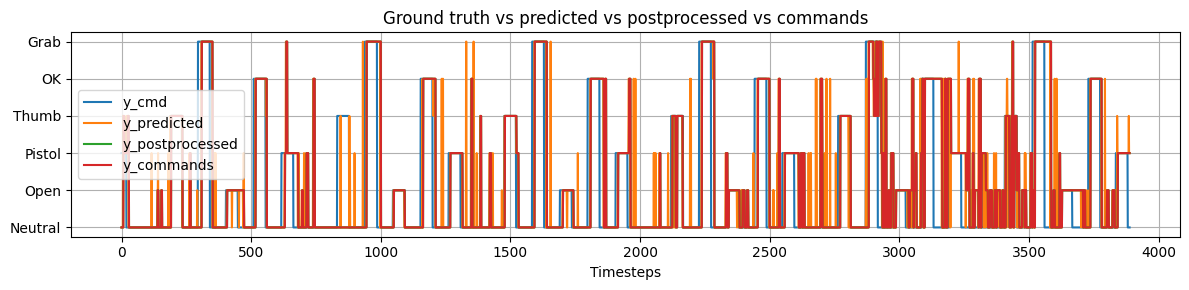

In [52]:
fig = plt.figure(figsize=(12, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [53]:
print(metrics.classification_report(
    y_test, y_dct['y_commands'], target_names=GESTURES
))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test, y_dct['y_commands'])
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

              precision    recall  f1-score   support

     Neutral       0.86      0.74      0.79      2489
        Open       0.49      0.83      0.62       276
      Pistol       0.55      0.76      0.64       295
       Thumb       0.86      0.65      0.74       276
          OK       0.58      0.78      0.67       276
        Grab       0.68      0.72      0.70       277

    accuracy                           0.74      3889
   macro avg       0.67      0.75      0.69      3889
weighted avg       0.78      0.74      0.75      3889



,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,1831,234,175,18,145,86
Open,42,230,4,0,0,0
Pistol,57,0,224,3,7,4
Thumb,90,0,4,179,0,3
OK,58,0,3,0,215,0
Grab,59,6,0,9,3,200


### Online (prosthesis or virtual hand)

In [54]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# ser_port = None
# # ser_port = '/dev/ttyACM0'
# # ser_port = '/dev/cu.usbmodem3498365F31351'

# if ser_port is not None:
#     ser = Serial(port=ser_port, timeout=2*TIMEOUT)
#     ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
#     ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
#     ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

#     # flush buffers
#     ser.reset_input_buffer()
#     ser.read()
    
#     i = 0;
#     while(ser.in_waiting):
#         print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#         ser.read_all()
#         time.sleep(0.005)
#         i+=1;
#     ser.readline()
#     ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# y_previous = None
# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = np.array(s.decode('UTF-8')\
#                            .replace('\r\n', "")\
#                            .split(' ')
#                          ).astype(int)
#         [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
#     except Exception as e:
#         print(e)
        
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed)
#     # [/Commands composition]
    
#     # [Commands sending]
#     pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     # [/Commands sending]
    
#     y_previous = y_postprocessed
    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         print('INPUT:\n', s)

#         # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
#         print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
#         print(y_commands)
#         print(pack)
    
#     ts_diff = time.time() - ts_start
#     assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 